#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV

#### Read data and segregate ordinal, nominal, continuous and discrete features

Here, we list and segregate the various features according to the data dictionary for convenience if we need to do any specific mapping or accessing of a group of data.

In [2]:
train = pd.read_csv('./datasets/train.csv')
# 23 Nominal, 23 Ordinal, 14 Discrete, 20 Continuous

ord_features = [
    'Lot Shape',
    'Utilities',
    'Land Slope',
    'Overall Qual',
    'Overall Cond',
    'Exter Qual',
    'Exter Cond',
    'Bsmt Qual',
    'Bsmt Cond',
    'Bsmt Exposure',
    'BsmtFin Type 1',
    'BsmtFin Type 2',
    'Heating QC',
    'Electrical',
    'Kitchen Qual',
    'Functional',
    'Fireplace Qu',
    'Garage Finish',
    'Garage Qual',
    'Garage Cond',
    'Paved Drive',
    'Pool QC',
    'Fence'    
]

nom_features = [
    'PID', #** Exclude PID as nom observation ids
    'MS SubClass',
    'MS Zoning',
    'Street',
    'Alley',
    'Land Contour',
    'Lot Config',
    'Neighborhood',
    'Condition 1',
    'Condition 2',
    'Bldg Type',
    'House Style',
    'Roof Style',
    'Roof Matl',
    'Exterior 1st',
    'Exterior 2nd',
    'Mas Vnr Type',
    'Foundation',
    'Heating',
    'Central Air',
    'Garage Type',
    'Misc Feature',
    'Sale Type',
#     'Sale Condition'
]

cont_features = [
    'Lot Frontage',
    'Lot Area',
    'Mas Vnr Area',
    'BsmtFin SF 1',
    'BsmtFin SF 2',
    'Bsmt Unf SF',
    'Total Bsmt SF',
    '1st Flr SF',
    '2nd Flr SF',
    'Low Qual Fin SF',
    'Gr Liv Area',
    'Garage Area',
    'Wood Deck SF',
    'Open Porch SF',
    'Enclosed Porch',
    '3Ssn Porch',
    'Screen Porch',
    'Pool Area',
    'Misc Val',
    #'SalePrice'
]


disc_features = [
    'Id',
    'Year Built',
    'Year Remod/Add',
    'Bsmt Full Bath',
    'Bsmt Half Bath',
    'Full Bath',
    'Half Bath',
    'Bedroom AbvGr',
    'Kitchen AbvGr',
    'TotRms AbvGrd',
    'Fireplaces',
    'Garage Yr Blt',
    'Garage Cars',
    'Mo Sold',
    'Yr Sold'
]


### Define helper functions

Helper functions are instantiated here to preload them, as they will be used for data cleaning and filtering later on.

#### Check NaN Values

In [3]:
def check_nan_values(df, col_lst):
    """
    Function checks for any NaN values in the provided list of features and returns list of features found to have
    NaN values
    
    Input -> Dataframe df, List col_lst
    Returns -> List ft_lst
    """
    ft_lst = []
    for feature in df.loc[:,(df[col_lst].isnull().sum() > 0).index].columns:
        if df[feature].isnull().values.any():
            ft_lst.append(feature)
    return ft_lst


In [4]:
def clean_data(df):
    """
    Function does data cleaning on dataset by filling NaN values with NA or 0, based on the type of feature in accordance
    to data dictionary
    
    Input -> Dataframe df
    Returns -> Dataframe df
    """
    
    # Clean nominal features
    df['Alley'] = df['Alley'].fillna('NA')
    df['Garage Type'] = df['Garage Type'].fillna('NA')
    df['Misc Feature'] = df['Misc Feature'].fillna('None')
    df['Mas Vnr Type'] = df['Mas Vnr Type'].map(lambda x: 'CBlock' if pd.isnull(x) else x)
    df['Central Air'] = df['Central Air'].map(lambda x: 1 if x == 'Y' else 0)
    
    # Clean Ordinal features
    for ft in check_nan_values(df,ord_features):
        df[ft] = df[ft].fillna('NA')
        
    # Clean continuous features
    for ft in check_nan_values(df,cont_features):
        df[ft] = df[ft].fillna(0)
        
    # Clean discrete features
    for ft in check_nan_values(df,disc_features):
        df[ft] = df[ft].fillna(0)
        
    return df

In [5]:
def ord_mapping(df):
    """
    Function specifically maps ordinal features to ranked integers. As the ordinal values are not sorted, and some 
    features have different ordinal values, they are individually mapped and ranked.
    
    Input -> Dataframe df
    Returns -> Dataframe df
    """
    
    
    df['Lot Shape'] = df['Lot Shape'].map({'IR1':0,'IR2':1, 'IR3':2,'Reg':3,})
    df['Utilities'] = df['Utilities'].map({'ELO':0,'NoSeWa':1, 'NoSewr':2,'AllPub':3})
    df['Land Slope'] = df['Land Slope'].map({'Sev':0, 'Mod':1,'Gtl':2})
    df['Exter Qual'] = df['Exter Qual'].map({'Po':0,'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    df['Exter Cond'] = df['Exter Cond'].map({'Po':0,'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    df['Bsmt Qual'] = df['Bsmt Qual'].map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['Bsmt Cond'] = df['Bsmt Cond'].map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['Bsmt Exposure'] = df['Bsmt Exposure'].map({'NA':0, 'No':1, 'Mn':2,'Av':3, 'Gd':4})
    df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
    df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
    df['Heating QC'] = df['Heating QC'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    df['Electrical'] = df['Electrical'].map({'Mix':0,'FuseP':1,'FuseF':2,'FuseA':3,'SBrkr':4})
    df['Kitchen Qual'] = df['Kitchen Qual'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
    df['Functional'] = df['Functional'].map({'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7})
    df['Fireplace Qu'] = df['Fireplace Qu'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    df['Garage Finish'] = df['Garage Finish'].map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
    df['Garage Qual'] = df['Garage Qual'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    df['Garage Cond'] = df['Garage Cond'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    df['Paved Drive'] = df['Paved Drive'].map({'N':0,'P':1,'Y':2})
    df['Pool QC'] = df['Pool QC'].map({'NA':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
    df['Fence'] = df['Fence'].map({'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4})
    return df

In [6]:
def check_frequency(df):
    
    """
    Function checks for frequency of values to measure first value of each feature, and see if it's skewed towards
    one value for every row, or if it's evenly spread, based on threshold of 70%
    
    Input -> Dataframe df
    Returns -> List[List,List] [keep_lst,remove_lst]
    """
    
    keep_lst = []
    remove_lst = []
    for feature in df.columns:
        if round((df[feature].value_counts().to_list()[0]/sum(df[feature].value_counts().to_list())) * 100,2) < 70:
            keep_lst.append(feature)
        else:
            remove_lst.append(feature)
        
    return [keep_lst, remove_lst]

In [7]:
def plot_3_scatter(df, columns, x):
    
    """
    Function takes in dataframe to show each feature and it's spread vs another feature (x)
    
    Input -> Dataframe df, List columns, String x
    
    """
    
    rows = round(len(columns)/3) if len(columns)%3 ==0 else round(len(columns)/3)+1
    
    fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(15,15*3))
    axr = axes.ravel()
    for idx, feature in enumerate(columns):
        scatter = sns.scatterplot(
            data=df,
            x=df[feature],
            y=df[x],
            ax=axr[idx]
        )

        scatter.set_xlabel(feature)
        scatter.set_ylabel(x)
    plt.tight_layout()
    if len(columns) % 3 != 0:
        axr.flat[-(len(columns)%3)].set_visible(False)
    plt.show()

In [8]:
def interaction_terms(df):
    df['Age'] = abs(df['Year Built'] - df['Yr Sold'])
    df['Overall Qual Liv Area'] = df['Overall Qual'] * df['Gr Liv Area']
    df['Overall Qual Ext Qual'] = df['Overall Qual'] * df['Exter Qual']
    return df

In [9]:
def drop_collinear(df):
    # Drop columns as they are represented by Total Bsmt Area, and Lot area, and are most likely collinear in nature
    df = df.drop(columns=['Id','PID','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','1st Flr SF','2nd Flr SF','Mo Sold','Yr Sold'])
    return df

In [10]:
def adjust_col_names(df):
    """
    Function takes in dataframe and lowercases feature names, and replaces spaces with underscore
    
    Input -> Dataframe df
    Returns -> Dataframe df
    
    """
    for col_name in df.columns:
        df.rename(columns={col_name: col_name.lower().replace(' ','_')}, inplace=True)
    return df

#### Clean and fix data with NaN

Clean dataset and map ordinal data

In [11]:
data = clean_data(train)
# train.info()

#### Ordinal column mapping

In [12]:
data = ord_mapping(data)

#### Check head and tail of fixed data

In [13]:
data = interaction_terms(data)

In [14]:
data = drop_collinear(data)

In [15]:
data = adjust_col_names(data)

In [16]:
data.head(3)

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,pool_area,pool_qc,fence,misc_feature,misc_val,sale_type,saleprice,age,overall_qual_liv_area,overall_qual_ext_qual
0,60,RL,0.0,13517,Pave,NA,0,Lvl,3,CulDSac,...,0,0,0,None,0,WD,130500,34,8874,18
1,60,RL,43.0,11492,Pave,NA,0,Lvl,3,CulDSac,...,0,0,0,None,0,WD,220000,13,14854,21
2,20,RL,68.0,7922,Pave,NA,3,Lvl,3,Inside,...,0,0,0,None,0,WD,109000,57,5285,10


In [17]:
data.tail(3)

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,pool_area,pool_qc,fence,misc_feature,misc_val,sale_type,saleprice,age,overall_qual_liv_area,overall_qual_ext_qual
2048,50,RL,57.0,7558,Pave,NA,3,Bnk,3,Inside,...,0,0,0,None,0,WD,177000,81,11478,12
2049,20,RL,80.0,10400,Pave,NA,3,Lvl,3,Corner,...,0,0,0,None,0,WD,144000,53,4800,8
2050,60,RL,60.0,7500,Pave,NA,3,Lvl,3,Inside,...,0,0,0,None,0,WD,189000,11,12628,14


We observe 1 record of Garage Yr Built at Year 2207. Deduced to be typo and imputed 2007 instead

In [18]:
data['garage_yr_blt'].describe()   # Noted typo of 2207. Deduced to be 2007 instead
data.loc[data['garage_yr_blt'] == 2207, 'garage_yr_blt'] = 2007

#### EDA: Previewing Data and Highlighting Outliers

We see that there are 2 outliers in the data set, shown as markers way beyond the 99% quartile. This is also specifically mentioned in the data dictionary for the training dataset.

<Figure size 1080x1080 with 0 Axes>

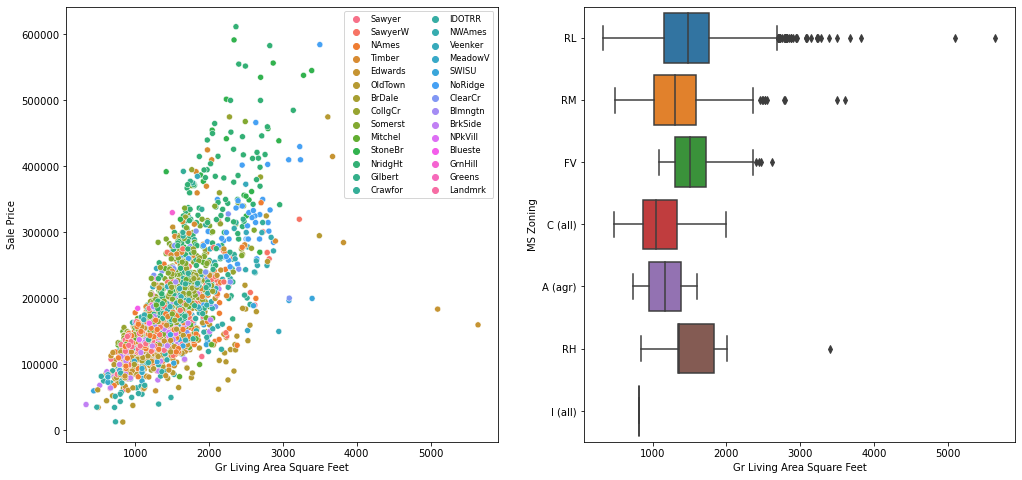

In [19]:
plt.figure(figsize=(15,15))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,8))
sns.scatterplot(data=data, y='saleprice',x='gr_liv_area', hue='neighborhood',ax=axes[0])
axes[0].legend(ncol=2, fontsize='small')
axes[0].set_xlabel('Gr Living Area Square Feet')
axes[0].set_ylabel('Sale Price')
sns.boxplot(data=data,y='ms_zoning', x='gr_liv_area',ax=axes[1])
axes[1].set_xlabel('Gr Living Area Square Feet')
axes[1].set_ylabel('MS Zoning')
plt.show()

To prevent these 2 outliers from skewing our fitting later when we perform our models, we will exclude these 2 records from our dataset. We now see a better spread of the data.

In [20]:
data.drop(data[data['gr_liv_area'] > data['gr_liv_area'].quantile(.99) + (data['gr_liv_area'].std() * 3)].index, inplace=True)
data.reset_index(inplace=True)

<Figure size 1080x1080 with 0 Axes>

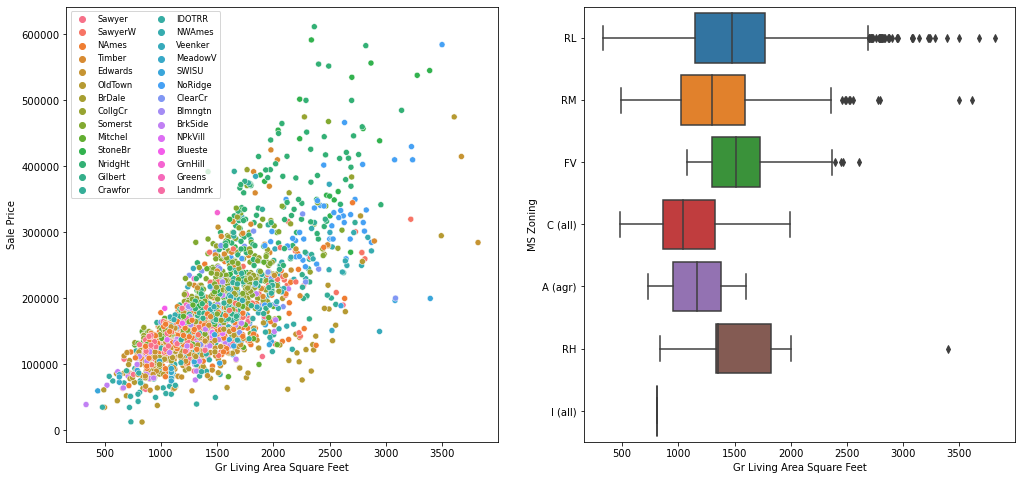

In [21]:
plt.figure(figsize=(15,15))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,8))
sns.scatterplot(data=data, y='saleprice',x='gr_liv_area', hue='neighborhood',ax=axes[0])
axes[0].legend(ncol=2, fontsize='small')
axes[0].set_xlabel('Gr Living Area Square Feet')
axes[0].set_ylabel('Sale Price')
sns.boxplot(data=data,y='ms_zoning', x='gr_liv_area',ax=axes[1])
axes[1].set_xlabel('Gr Living Area Square Feet')
axes[1].set_ylabel('MS Zoning')
plt.show()

When we see the data in the scatter diagram with the square feet of the ground living area versus the Sale Price, we can see that as the sale price and the square feet of the ground living area increases, the overall quality also increases. The pattern is noted in the chart on the right, with blue showing houses with lower quality, correlated to lower sale price and ground living area square feet, and gradually increasing as the square feet of the living area increases.

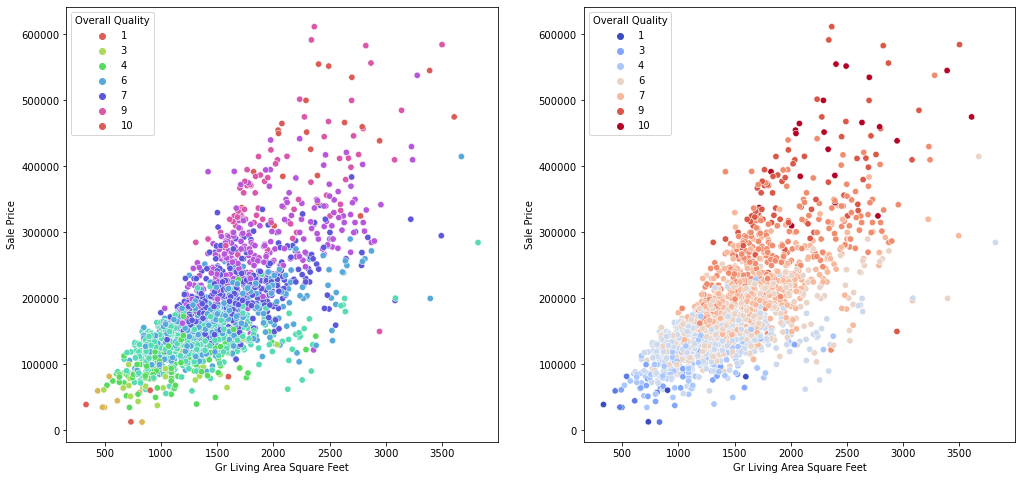

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,8))
sns.scatterplot(data=data,x='gr_liv_area',y='saleprice',hue='overall_qual',palette='hls', s=40, ax=axes[0])
axes[0].legend(title='Overall Quality')
axes[0].set_xlabel('Gr Living Area Square Feet')
axes[0].set_ylabel('Sale Price')
sns.scatterplot(data=data,x='gr_liv_area',y='saleprice',hue='overall_qual',palette='coolwarm', s=40, ax=axes[1])
axes[1].legend(title='Overall Quality')
axes[1].set_xlabel('Gr Living Area Square Feet')
axes[1].set_ylabel('Sale Price')
plt.show();

We also note that the quality of the exterior shows a similar cluster to the overall quality, which could attribute that a better quality of the exterior is a factor in the overall quality of the house.

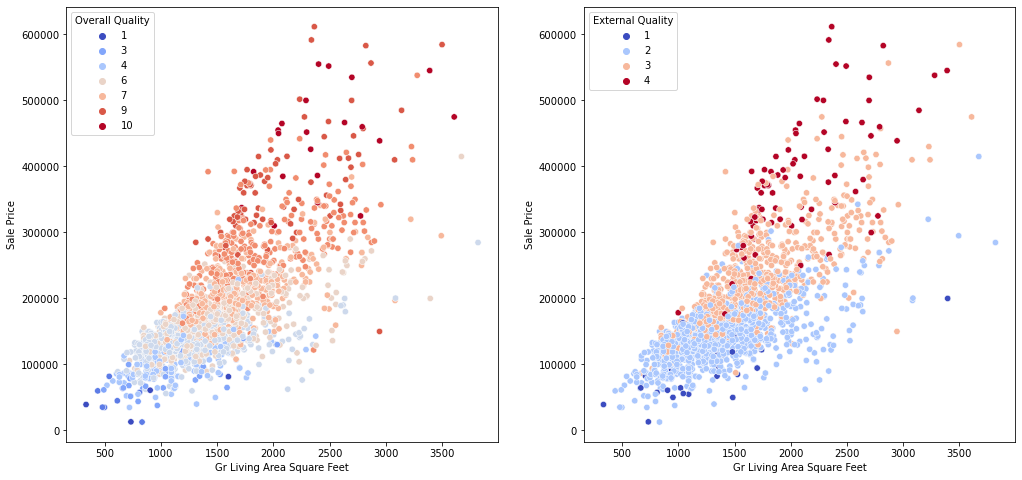

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,8))
sns.scatterplot(data=data,x='gr_liv_area',y='saleprice',hue='overall_qual',palette='coolwarm', s=40, ax=axes[0])
axes[0].legend(title='Overall Quality')
axes[0].set_xlabel('Gr Living Area Square Feet')
axes[0].set_ylabel('Sale Price')
sns.scatterplot(data=data,x='gr_liv_area',y='saleprice',hue='exter_qual',palette='coolwarm', s=40, ax=axes[1])
axes[1].legend(title='External Quality')
axes[1].set_xlabel('Gr Living Area Square Feet')
axes[1].set_ylabel('Sale Price')
plt.show();

This would suggest that the creation of interaction terms between overall quality (overall_qual), square foot of living area (gr_liv_area) and quality of exterior materials (exter_qual) might be significantly correlated to the saleprice. We can see the coefficients based on the correlation heatmap below.

<AxesSubplot:>

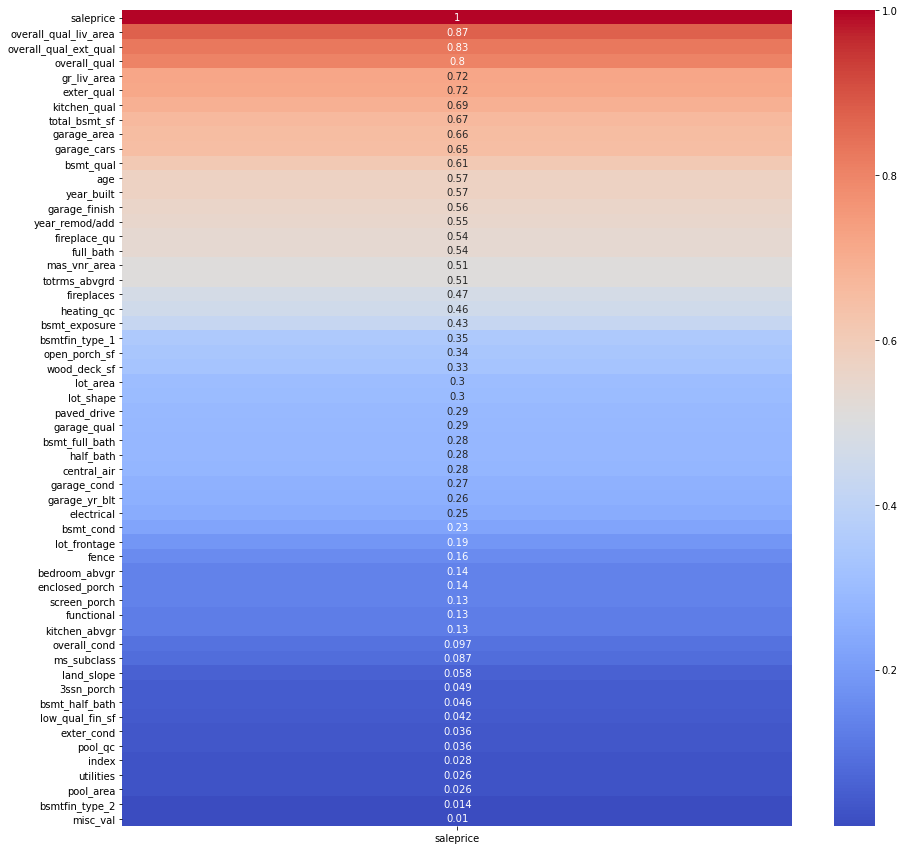

In [24]:
plt.figure(figsize=(15,15))
sns.heatmap(abs(data.corr()[['saleprice']]).sort_values(ascending=False, by='saleprice'), annot=True, cmap='coolwarm')

#### Extract main features to main dataframe

There are categorical, nominal and possibly discrete features that have majority of the values skewed to more than 70% of the 2049 records in the train set. The check_frequency function assesses all the features in the train dataset, uses 70% as a threshold and picks out features that doesn't have any values appearing more than 70% of the time. These features are then used as the main dataframe to train and fit our regression models for prediction.

In [25]:
ft_to_keep = check_frequency(data)[0]
ft_to_keep.remove('index')
new_data = data[ft_to_keep]

### Model 1: Selection of small features assumed to be best suited

In [26]:
X = new_data[['overall_cond','overall_qual','gr_liv_area','overall_qual_liv_area','overall_qual_ext_qual']]
y = new_data['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
coeff = pd.DataFrame({'Feature': X_train.columns.tolist(), 'Coefficients':lr.coef_})
coeff

,Feature,Coefficients
0,overall_cond,3123.055668
1,overall_qual,-19580.732981
2,gr_liv_area,-50.433071
3,overall_qual_liv_area,18.706612
4,overall_qual_ext_qual,5316.039939


In [28]:
print(f'Train RMSE: {mean_squared_error(y_train,lr.predict(X_train))**0.5}')
print(f'Test RMSE: {mean_squared_error(y_test, lr.predict(X_test)) **0.5}')

Train RMSE: 34700.41356156656
Test RMSE: 33440.92119339446


### Model 2: Using all numeric features in our shortlisted features

In [29]:
X = new_data.select_dtypes(include=['int64','float64']).drop(columns='saleprice')
y = new_data['saleprice']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [30]:
coeff = pd.DataFrame({'Feature': X_train.columns.tolist(),'Coefficients':lr.coef_})
coeff.sort_values(ascending=False, by='Coefficients')

,Feature,Coefficients
32,overall_qual_ext_qual,10649.945928
5,overall_cond,9551.674602
20,kitchen_qual,6879.807129
17,full_bath,5298.547593
11,bsmt_exposure,4769.632245
23,fireplace_qu,4136.733114
16,bsmt_full_bath,3463.637814
12,bsmtfin_type_1,1789.727768
21,totrms_abvgrd,603.275043
14,heating_qc,487.931819


In [31]:
print(f'Train RMSE: {mean_squared_error(y_train,lr.predict(X_train))**0.5}')
print(f'Test RMSE: {mean_squared_error(y_test, lr.predict(X_test)) **0.5}')

Train RMSE: 23965.785404588078
Test RMSE: 24899.342958656125


### Train, Test, Split for Modelling

In [32]:
nom_cols = new_data.select_dtypes(include='object').columns
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_ohe = ohe.fit_transform(new_data[nom_cols])
bin_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names(nom_cols))
cont_df = new_data.drop(columns=nom_cols)

In [33]:
cont_ft = cont_df.columns.drop('saleprice')
nom_ft = bin_df.columns
full_df = pd.concat([cont_df,bin_df], axis=1)
X = full_df.drop(columns='saleprice')
y = full_df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)


### Model 3: Binarised Nominal Columns on Linear Regression

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [35]:
coeff = pd.DataFrame({'Feature': X_train.columns.tolist(),'Coefficients':lr.coef_})
coeff.sort_values(ascending=False, by='Coefficients').head(20)

,Feature,Coefficients
43,neighborhood_GrnHill,130659.510412
65,house_style_2.5Unf,43277.769347
114,garage_type_CarPort,36982.353613
58,neighborhood_StoneBr,36262.233583
96,exterior_2nd_VinylSd,31087.020418
39,neighborhood_Crawfor,25764.290729
79,exterior_1st_Stone,24663.424442
69,exterior_1st_AsbShng,23883.078801
108,foundation_Stone,21360.213644
113,garage_type_BuiltIn,17111.237267


In [36]:
print(f'Train RMSE: {mean_squared_error(y_train,lr.predict(X_train))**0.5}')
print(f'Test RMSE: {mean_squared_error(y_test, lr.predict(X_test)) **0.5}')

Train RMSE: 19045.07373517182
Test RMSE: 26280.483259643668


### Scaling of train and test set

In [37]:
ss = StandardScaler()
X_train_sc_cont, X_test_sc_cont = ss.fit_transform(X_train[cont_ft]), ss.transform(X_test[cont_ft])

X_train_ss = X_train.drop(columns=cont_ft).reset_index(drop=True).join(pd.DataFrame(X_train_sc_cont, columns=cont_ft))
X_test_ss = X_test.drop(columns=cont_ft).reset_index(drop=True).join(pd.DataFrame(X_test_sc_cont, columns=cont_ft))

### Model 4: Ridge CV

In [38]:
r_alphas = np.logspace(0,5,100)
ridge_cv = RidgeCV(alphas=r_alphas, cv=5)
ridge_cv.fit(X_train_ss,y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5)

In [39]:
ridge_coeff = pd.DataFrame({'Feature': X_train_ss.columns.tolist(),'Coefficients':ridge_cv.coef_})
ridge_coeff.sort_values(ascending=False, by='Coefficients').head(20)

,Feature,Coefficients
115,overall_qual_liv_area,43259.727603
116,overall_qual_ext_qual,31531.317121
25,neighborhood_StoneBr,30676.896259
10,neighborhood_GrnHill,28673.140278
32,house_style_2.5Unf,20280.193639
6,neighborhood_Crawfor,19379.045244
19,neighborhood_NridgHt,13256.368924
39,exterior_1st_BrkFace,11619.258023
56,exterior_2nd_CmentBd,10455.332239
70,mas_vnr_type_Stone,10208.839274


In [40]:
print(ridge_cv.alpha_)

2.8480358684358014


In [41]:
print(mean_squared_error(y_train, ridge_cv.predict(X_train_ss))**0.5)
print(mean_squared_error(y_test, ridge_cv.predict(X_test_ss))**0.5)

20614.62380381593
24443.39919759931


### Model 5: Lasso CV

In [42]:
l_alphas = np.logspace(-3,0,100)
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=10000, tol=0.00001)
lasso_cv.fit(X_train_ss, y_train)

/Users/khalis/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34460257.51998901, tolerance: 22113882.358594373
  model = cd_fast.enet_coordinate_descent_gram(


LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
        cv=5, max_iter=10000, tol=1e-05)

In [43]:
lasso_coeff = pd.DataFrame({'Feature': X_train_ss.columns.tolist(),'Coefficients':lasso_cv.coef_})
lasso_coeff.sort_values(ascending=False, by='Coefficients').head(20)

,Feature,Coefficients
10,neighborhood_GrnHill,138509.967625
115,overall_qual_liv_area,61461.455267
116,overall_qual_ext_qual,54379.715287
25,neighborhood_StoneBr,44856.203462
32,house_style_2.5Unf,43116.337772
6,neighborhood_Crawfor,34482.374490
63,exterior_2nd_VinylSd,27725.355338
46,exterior_1st_Stone,26259.766982
36,exterior_1st_AsbShng,25054.410893
75,foundation_Stone,24340.181990


In [44]:
print(lasso_cv.alpha_)

1.0


In [45]:
print(mean_squared_error(y_train, lasso_cv.predict(X_train_ss))**0.5)
print(mean_squared_error(y_test, lasso_cv.predict(X_test_ss))**0.5)

19046.7711406036
26182.499067267705


### Model 6: ElasticNet

In [46]:
enet_alphas = np.linspace(0.1,1.0,100)
enet_ratio = np.logspace(-3,0,100)
enet_cv = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, max_iter=10000)
enet_cv.fit(X_train_ss, y_train)

ElasticNetCV(alphas=array([0.1       , 0.10909091, 0.11818182, 0.12727273, 0.13636364,
       0.14545455, 0.15454545, 0.16363636, 0.17272727, 0.18181818,
       0.19090909, 0.2       , 0.20909091, 0.21818182, 0.22727273,
       0.23636364, 0.24545455, 0.25454545, 0.26363636, 0.27272727,
       0.28181818, 0.29090909, 0.3       , 0.30909091, 0.31818182,
       0.32727273, 0.33636364, 0.34545455, 0.35454545, 0.36363636,
       0.37272727, 0.3...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
             max_iter=10000)

In [47]:
enet_coeff = pd.DataFrame({'Feature': X_train_ss.columns.tolist(),'Coefficients':enet_cv.coef_})
enet_coeff.sort_values(ascending=False, by='Coefficients').head(20)

,Feature,Coefficients
115,overall_qual_liv_area,41854.732488
116,overall_qual_ext_qual,30048.336321
25,neighborhood_StoneBr,29776.620718
10,neighborhood_GrnHill,25739.430822
32,house_style_2.5Unf,18853.253197
6,neighborhood_Crawfor,18676.649561
19,neighborhood_NridgHt,13227.553238
39,exterior_1st_BrkFace,11261.972349
56,exterior_2nd_CmentBd,10086.080610
70,mas_vnr_type_Stone,10040.372072


In [48]:
print(enet_cv.alpha_)
print(enet_cv.l1_ratio_)

0.1181818181818182
0.9326033468832199


In [49]:
print(mean_squared_error(y_train, enet_cv.predict(X_train_ss))**0.5)
print(mean_squared_error(y_test, enet_cv.predict(X_test_ss))**0.5)

20774.155679861364
24427.058368823116


### Test with Kaggle Dataset

In [50]:
test_df = pd.read_csv('./datasets/test.csv')
test = clean_data(test_df)
test = ord_mapping(test)
test = interaction_terms(test)
test = drop_collinear(test)
test = adjust_col_names(test)
test = test[new_data.columns.drop('saleprice')]

In [51]:
X_test_ohe = ohe.transform(test[nom_cols])
X_test_bin_df = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(nom_cols))
X_test_cont_df = test.drop(columns=nom_cols)
X_test = pd.concat([X_test_cont_df,X_test_bin_df],axis=1)

In [52]:
ss = StandardScaler()
X_train_sc_cont, X_test_sc_cont = ss.fit_transform(X[cont_ft]), ss.transform(X_test[cont_ft])
X_train_ss = X.drop(columns=cont_ft).reset_index(drop=True).join(pd.DataFrame(X_train_sc_cont, columns=cont_ft))
X_test_ss = X_test.drop(columns=cont_ft).reset_index(drop=True).join(pd.DataFrame(X_test_sc_cont, columns=cont_ft))

r_alphas = np.logspace(0,5,100)
ridge_cv = RidgeCV(alphas=r_alphas, cv=5)
ridge_cv.fit(X_train_ss,y)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5)

In [53]:
X_test

,ms_subclass,lot_frontage,lot_area,lot_shape,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,...,foundation_Slab,foundation_Stone,foundation_Wood,garage_type_2Types,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_NA
0,190,69.0,9142,3,6,8,1910,1950,0.0,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,90,0.0,9662,0,5,4,1977,1977,0.0,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,60,58.0,17104,0,7,5,2006,2006,0.0,3,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,30,60.0,8520,3,5,6,1923,2006,0.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,20,0.0,9500,0,6,5,1963,1963,247.0,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,60,80.0,8000,3,6,6,1974,1974,0.0,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
874,60,90.0,14670,3,6,7,1966,1999,410.0,3,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
875,20,55.0,8250,3,5,5,1968,1968,0.0,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
876,20,60.0,9000,3,4,6,1971,1971,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [54]:
ridge_coeff = pd.DataFrame({'Feature': X_train_ss.columns.tolist(),'Coefficients':ridge_cv.coef_})
ridge_coeff.sort_values(ascending=False, by='Coefficients').head(20)

,Feature,Coefficients
115,overall_qual_liv_area,53637.537276
10,neighborhood_GrnHill,44320.539464
116,overall_qual_ext_qual,40981.616685
25,neighborhood_StoneBr,28385.725143
39,exterior_1st_BrkFace,17165.041187
6,neighborhood_Crawfor,14572.219737
19,neighborhood_NridgHt,12509.657864
16,neighborhood_NPkVill,9682.232921
74,foundation_Slab,9343.249686
97,total_bsmt_sf,8274.336579


In [55]:
print(ridge_cv.alpha_)

2.8480358684358014


In [56]:
print(mean_squared_error(y, ridge_cv.predict(X_train_ss))**0.5)

21353.453000744183


In [57]:
preds = ridge_cv.predict(X_test_ss)

In [58]:
pred_to_df = pd.DataFrame(preds, columns=['SalePrice'])
output = test_df.merge(pred_to_df, how='left', left_index=True, right_index=True)
output.loc[:,['Id','SalePrice']].to_csv('./datasets/test_ridge_model.csv', index=False)